In [1]:
# LSTM forecasting with PyTorch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
# Load cleaned dataset
df = pd.read_csv("../data/processed/train_clean.csv", parse_dates=["date"])

store_id = 1
item_id = 1

series = (
    df[(df["store"] == store_id) & (df["item"] == item_id)]
    .sort_values("date")[["date", "sales"]]
    .reset_index(drop=True)
)

print(series.head())
print("Length:", len(series))
print("Date range:", series["date"].min().date(), "to", series["date"].max().date())


        date  sales
0 2013-01-01     13
1 2013-01-02     11
2 2013-01-03     14
3 2013-01-04     13
4 2013-01-05     10
Length: 1826
Date range: 2013-01-01 to 2017-12-31


In [3]:
# Scale sales for stable training
scaler = MinMaxScaler()
series["sales_scaled"] = scaler.fit_transform(series[["sales"]])

def create_sequences(values, window=30):
    X, y = [], []
    for i in range(window, len(values)):
        X.append(values[i-window:i])
        y.append(values[i])
    return np.array(X), np.array(y)

window = 30
values = series["sales_scaled"].values
X, y = create_sequences(values, window)

print("X shape:", X.shape)  # (samples, window)
print("y shape:", y.shape)

# Train/test split by time (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM: (batch, seq_len, features)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X shape: (1796, 30)
y shape: (1796,)
X_train: (1436, 30, 1) X_test: (360, 30, 1)


In [4]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32

train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)           # out: (batch, seq_len, hidden)
        out = out[:, -1, :]             # last time step
        out = self.fc(out)              # (batch, 1)
        return out

model = LSTMForecaster(input_size=1, hidden_size=50, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


LSTMForecaster(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [6]:
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(-1)  # (batch, 1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(-1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {np.mean(train_losses):.6f} | "
        f"Val Loss: {np.mean(val_losses):.6f}"
    )


Epoch 01 | Train Loss: 0.061641 | Val Loss: 0.025097
Epoch 02 | Train Loss: 0.017180 | Val Loss: 0.020023
Epoch 03 | Train Loss: 0.016040 | Val Loss: 0.018148
Epoch 04 | Train Loss: 0.015176 | Val Loss: 0.018136
Epoch 05 | Train Loss: 0.014524 | Val Loss: 0.016249
Epoch 06 | Train Loss: 0.014114 | Val Loss: 0.016086
Epoch 07 | Train Loss: 0.013596 | Val Loss: 0.016211
Epoch 08 | Train Loss: 0.014583 | Val Loss: 0.017522
Epoch 09 | Train Loss: 0.013760 | Val Loss: 0.016694
Epoch 10 | Train Loss: 0.013932 | Val Loss: 0.016192
Epoch 11 | Train Loss: 0.013573 | Val Loss: 0.018190
Epoch 12 | Train Loss: 0.014184 | Val Loss: 0.016748
Epoch 13 | Train Loss: 0.013528 | Val Loss: 0.016411
Epoch 14 | Train Loss: 0.014075 | Val Loss: 0.016204
Epoch 15 | Train Loss: 0.013528 | Val Loss: 0.016029
Epoch 16 | Train Loss: 0.013954 | Val Loss: 0.016465
Epoch 17 | Train Loss: 0.013916 | Val Loss: 0.016847
Epoch 18 | Train Loss: 0.013502 | Val Loss: 0.016102
Epoch 19 | Train Loss: 0.013898 | Val Loss: 0.

In [7]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_tensor).cpu().numpy().reshape(-1)

# Inverse scaling
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"LSTM (PyTorch) → MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}")


LSTM (PyTorch) → MAE: 4.67, RMSE: 5.88, MAPE: 25.04


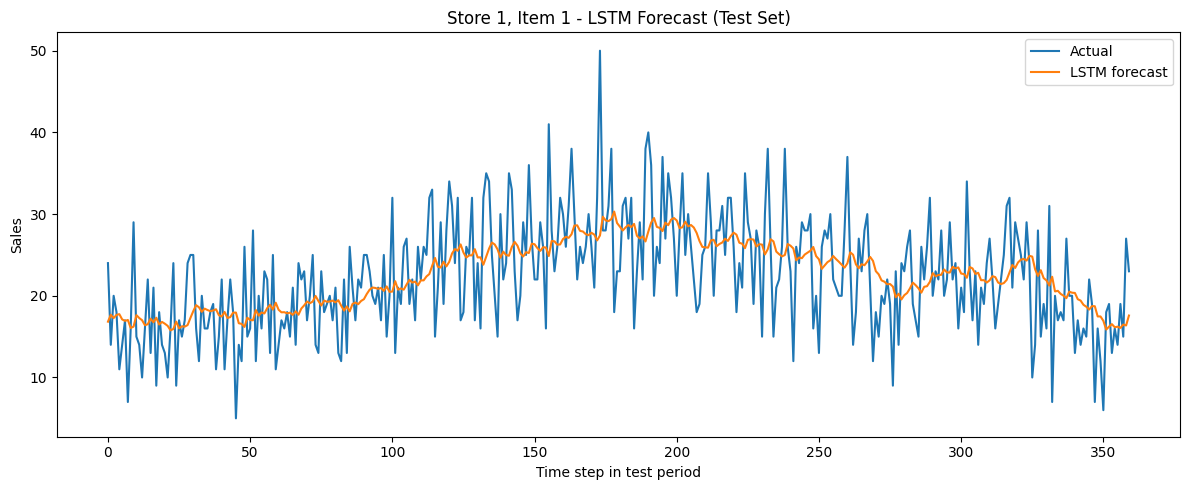

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="LSTM forecast")
plt.title(f"Store {store_id}, Item {item_id} - LSTM Forecast (Test Set)")
plt.xlabel("Time step in test period")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
